## IoT ML

This [mini-course on time-series analysis](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3) in Python, by Dmitriy Sergeev was extremely helpful!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import seaborn as sns

In [6]:
power = pd.read_csv('Data/household_power_consumption.csv', parse_dates=['Date_Time'])
power = power.set_index('Date_Time')
power.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen,Laundry,Heat_AC
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
for i in list(power.columns):
    power = power[pd.to_numeric(power[i], errors='coerce').notnull()]

for i in list(power.columns):
    power[[i]] = power[[i]].astype('float32')

print(power.dtypes)
print(len(power))

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Kitchen                  float32
Laundry                  float32
Heat_AC                  float32
dtype: object
129592


## Statistical Smoothing Techniques

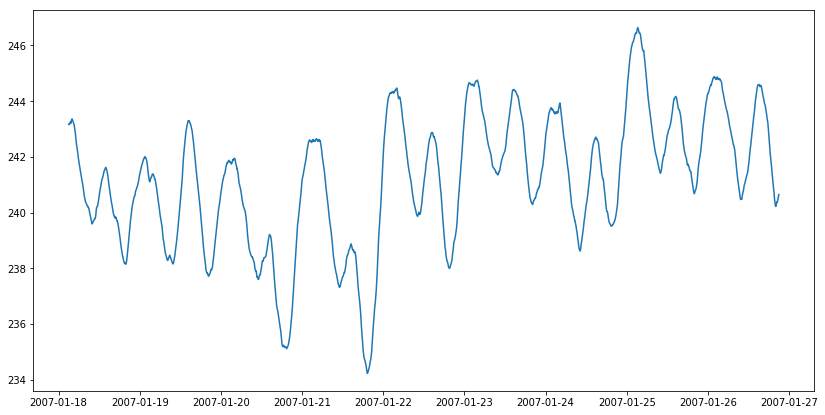

In [16]:
#  output over the course of a week, rolling averaged over the past 6 hours
plt.figure(figsize=(14, 7))
voltage = power.loc['2007-01-18':'2007-01-26', ['Voltage']]
plt.plot(voltage.rolling(360, center=True).mean())

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing

In [18]:
train = power.loc['2007-01-18':'2007-01-24', ['Voltage']]
test = power.loc['2007-01-25':'2007-01-26', ['Voltage']]
len(test)

2880

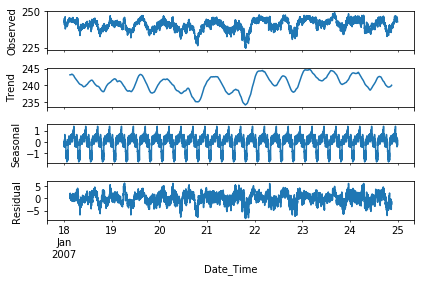

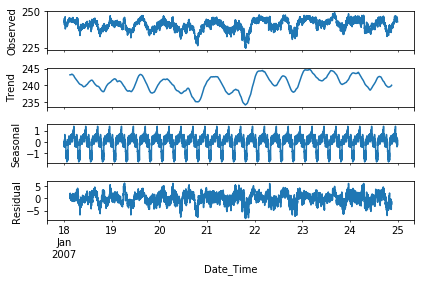

In [19]:
# Not sure what frequency should be set to or what it means, but this is interesting
sm.tsa.seasonal_decompose(train, freq = 360).plot()

In [20]:
train = power.loc['2007-01-18':'2007-01-24', ['Voltage']].resample('H').mean()
test = power.loc['2007-01-25':'2007-01-26', ['Voltage']].resample('H').mean()

In [21]:
fit1 = ExponentialSmoothing(np.asarray(train), seasonal_periods = 24, seasonal = 'add', trend = 'add' ).fit()

In [22]:
y_hat_avg = test.copy()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

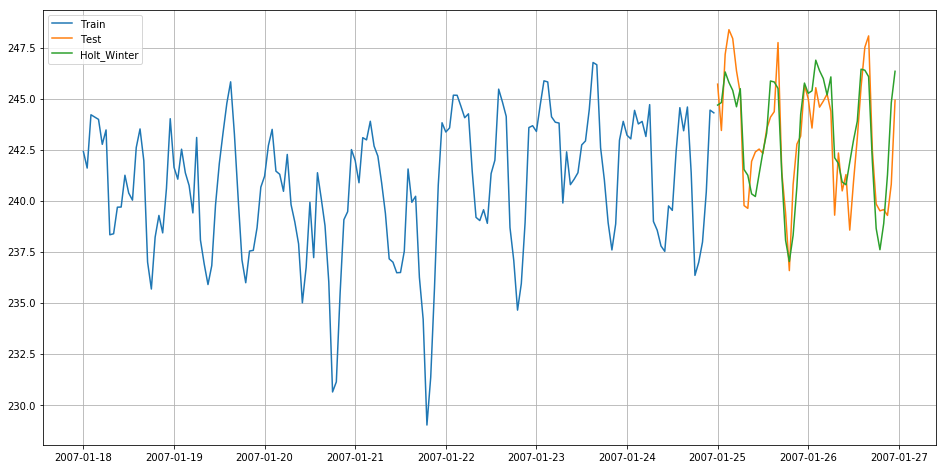

In [23]:
plt.figure(figsize=(16,8))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.grid()
plt.savefig('Figures/Holt_Winter.png')
plt.show()

In [24]:
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

In [25]:

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(power.Voltage, 1440) # prediction for the last observed day (past 24 hours)

240.15312

In [27]:
volts = power.loc['2007-01-18':'2007-01-26', ['Voltage']]
volts_hourly =power.loc['2007-01-18':'2007-01-26', ['Voltage']].resample('H').mean()
print(len(volts), len(volts_hourly))

12960 216


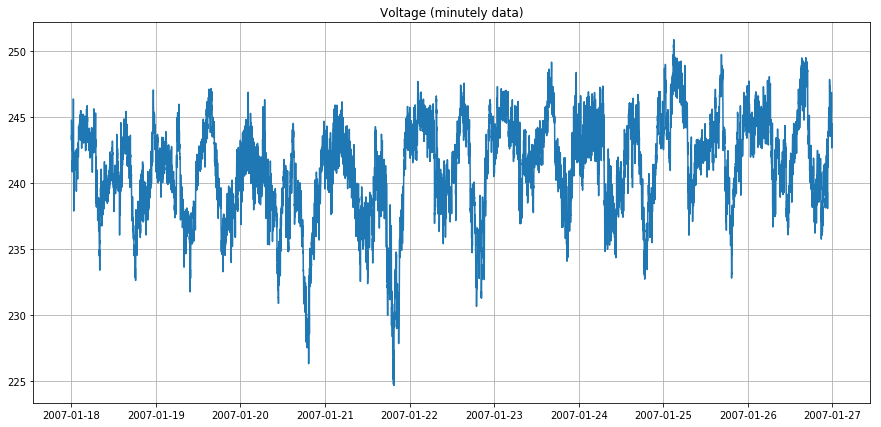

In [28]:
plt.figure(figsize=(15, 7))
plt.plot(power.loc['2007-01-18':'2007-01-26', ['Voltage']])
plt.title('Voltage (minutely data)')
plt.grid(True)
plt.show()

In [29]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

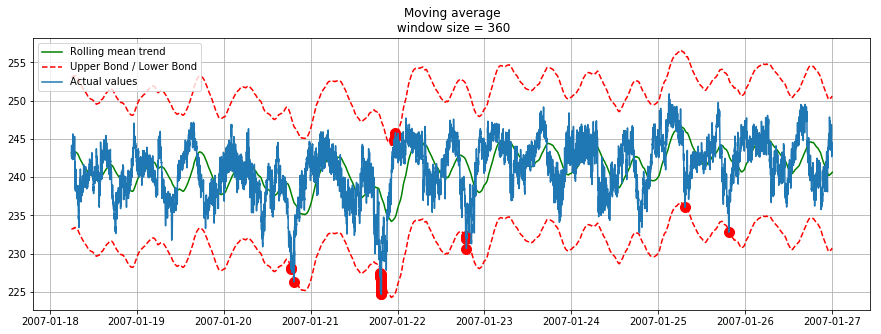

In [30]:
plotMovingAverage(volts, 360, plot_intervals = True, plot_anomalies = True)

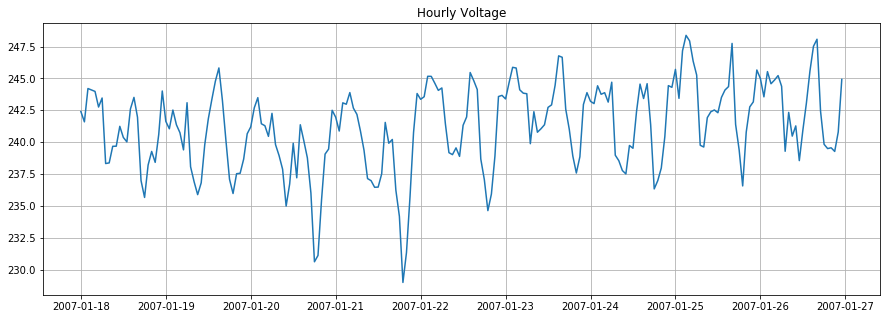

In [31]:
plt.figure(figsize=(15,5))
plt.plot(volts_hourly)
plt.title('Hourly Voltage')
plt.grid(True)
plt.savefig('Figures/volts_hourly.png')

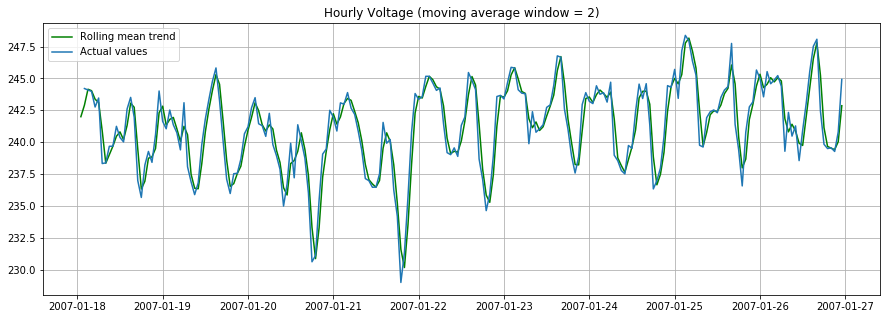

In [32]:
plotMovingAverage(volts_hourly, 2)
plt.title('Hourly Voltage (moving average window = 2)')
plt.savefig('Figures/volts_hourly_avg.png')

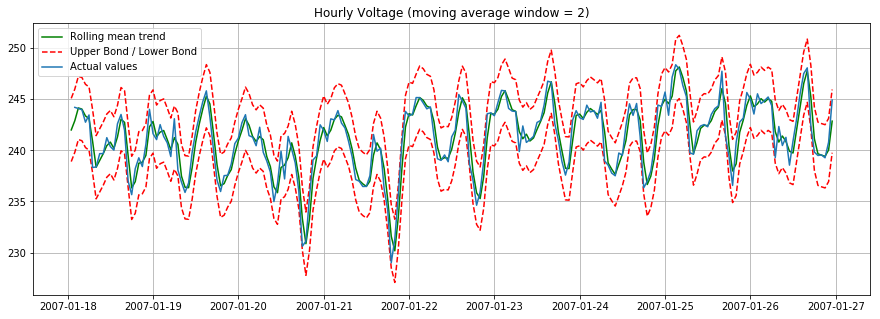

In [33]:
plotMovingAverage(volts_hourly, 2, plot_intervals = True)
plt.title('Hourly Voltage (moving average window = 2)')
plt.savefig('Figures/volts_hourly_avg_intervals.png')

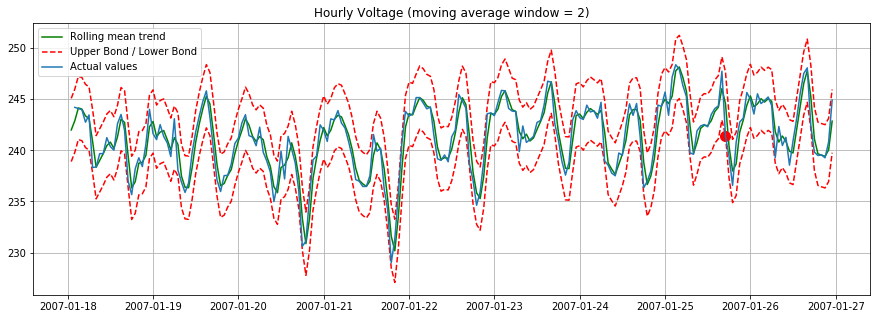

In [34]:
plotMovingAverage(volts_hourly, 2, plot_intervals = True, plot_anomalies = True)
plt.title('Hourly Voltage (moving average window = 2)')
plt.savefig('Figures/volts_hourly_avg_intervals_anomalies.png')

### Kitchen

In [35]:
kitchen = power.loc['2007-01-18':'2007-01-26', ['Kitchen']]
kitchen_hourly =power.loc['2007-01-18':'2007-01-26', ['Kitchen']].resample('H').mean()
print(len(kitchen), len(kitchen_hourly))

12960 216


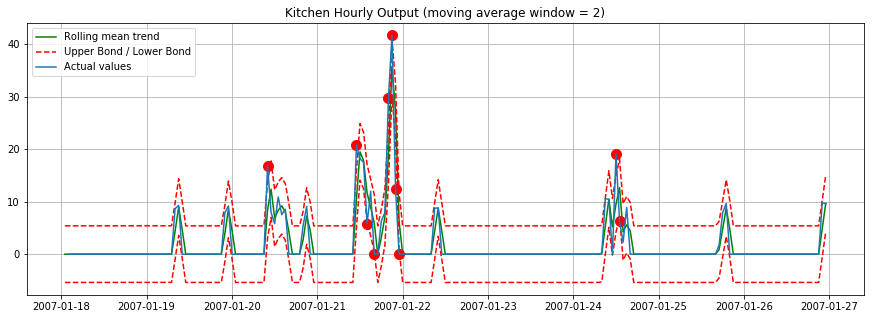

In [36]:
plotMovingAverage(kitchen_hourly, 2, plot_intervals=True, plot_anomalies=True)
plt.title('Kitchen Hourly Output (moving average window = 2)')
plt.savefig('Figures/kitchen_hourly_avg_intervals_anomalies.png')

---

---

---

---

## Predictive Voltage Regressor

In [37]:
data = power.loc['2007-01-18':'2007-01-26', ['Global_active_power', 'Voltage','Laundry', 'Heat_AC', 'Kitchen']]

In [38]:
# changing dtypes from object to numeric
for i in list(data.columns):
    data[[i]] = data[[i]].apply(pd.to_numeric)
data.dtypes

Global_active_power    float32
Voltage                float32
Laundry                float32
Heat_AC                float32
Kitchen                float32
dtype: object

In [39]:
data = data.resample('H').mean()
print(len(data))
#data.head()

216


In [40]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 12):
    data["lag_{}".format(i)] = data['Voltage'].shift(i)

data = data.dropna()
len(data)

205

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [42]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [44]:
y = data.dropna().Voltage
X = data.dropna().drop(['Voltage'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
X_train.round(2).head()

,Global_active_power,Laundry,Heat_AC,Kitchen,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Date_Time,,,,,,,,,,,,,,,
2007-01-18 11:00:00,0.28,0.10,0.00,0.0,239.679993,239.679993,238.380005,238.330002,243.460007,242.759995,243.979996,244.089996,244.210007,241.589996,242.399994
2007-01-18 12:00:00,0.31,0.33,0.00,0.0,241.240005,239.679993,239.679993,238.380005,238.330002,243.460007,242.759995,243.979996,244.089996,244.210007,241.589996
2007-01-18 13:00:00,0.51,0.23,0.00,0.0,240.369995,241.240005,239.679993,239.679993,238.380005,238.330002,243.460007,242.759995,243.979996,244.089996,244.210007
2007-01-18 14:00:00,0.37,0.20,0.00,0.0,240.020004,240.369995,241.240005,239.679993,239.679993,238.380005,238.330002,243.460007,242.759995,243.979996,244.089996
2007-01-18 15:00:00,0.61,0.38,4.38,0.0,242.600006,240.020004,240.369995,241.240005,239.679993,239.679993,238.380005,238.330002,243.460007,242.759995,243.979996


In [45]:
# machine learning in two lines
ridge = Ridge(alpha=.001)
ridge.fit(X_train, y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [46]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [47]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 5))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

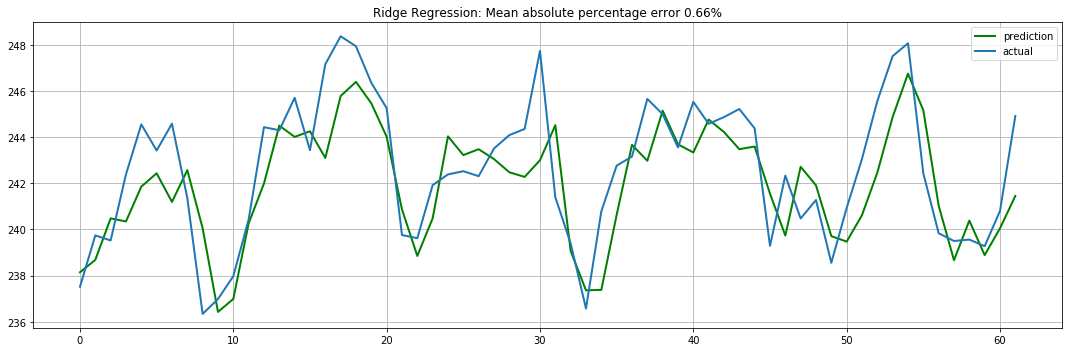

In [48]:
plotModelResults(ridge, plot_intervals=False)
plt.title('Ridge Regression: Mean absolute percentage error 0.66%')
plt.savefig('Figures/ridge_volts_pred.png')